In [1]:
import pandas as pd
import stopwordsiso as stopwords
import numpy as np
import string

# Topic Modeling 

Topic Modeling là phân tích chủ đề. Tức là từ một đống documents khi mà input vô model này, tùy vào mục đích ta sẽ có output dưới một số dạng như sau.

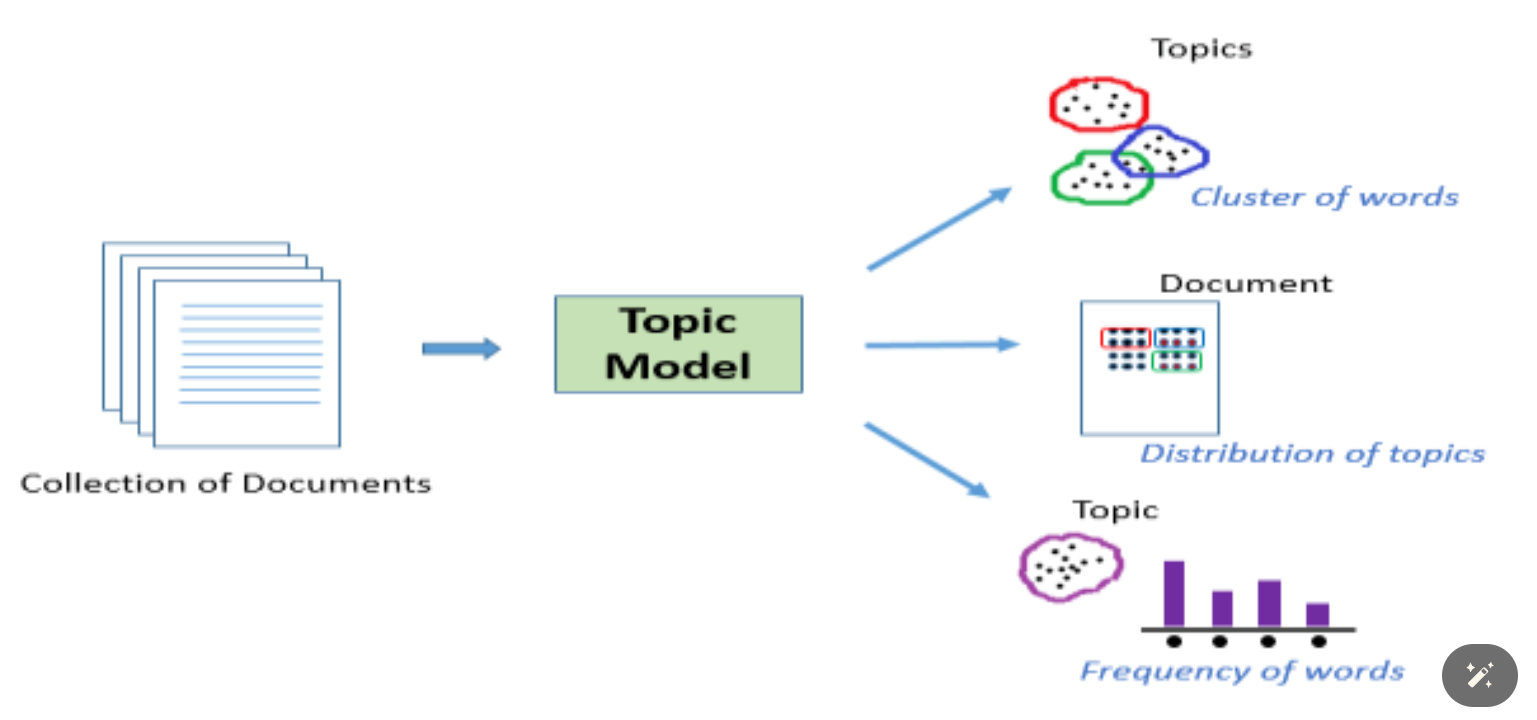

## Importing Data

In [2]:
df = pd.read_csv('new_file1.csv')
df.head(2)

C:\Users\darkn\AppData\Local\Temp\ipykernel_26904\2363274438.py:1: DtypeWarning: Columns (17,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('new_file1.csv')


,hotel_id,hotel_name,addressline1,city,state,numberrooms,yearopened,yearrenovated,number_of_reviews,rating_average,...,reviewtitle,comment,positive,negative,score,accommodationtype1,accommodationtype2,accommodationtype3,accommodationtype4,language
0,163,Ramana Saigon Hotel,"323 Le Van Sy Street, District 3",Ho Chi Minh City,Ho Chi Minh,296.0,1996.0,2015.0,1713,8.1,...,HCM Short Trip”,A tourist class hotel with very basic amenitie...,NaN,NaN,6.4,Hotel,NaN,NaN,NaN,en
1,163,Ramana Saigon Hotel,"323 Le Van Sy Street, District 3",Ho Chi Minh City,Ho Chi Minh,296.0,1996.0,2015.0,1713,8.1,...,Hospitality low ”,The hotel rooms etc are good but very very sti...,NaN,NaN,7.6,Hotel,NaN,NaN,NaN,en


In [3]:
topic_data = df[['national','language','comment']]
topic_data.head(5)

,national,language,comment
0,Singapore,en,A tourist class hotel with very basic amenitie...
1,Ấn Độ,en,The hotel rooms etc are good but very very sti...
2,Canada,en,Really enjoy my stay here. Will stay again
3,Việt Nam,en,excellent
4,Nhật Bản,ja,トランジットとして泊まる分には、良いホテルだと思います。


## Preprocessing

Trước khi vào step này, chúng ta cần discuss một xíu về paper này `https://aclanthology.org/E17-2069/`:

Summary lại một chút:
- **Traditional Assumption**:
  - Bỏ stopword improve quality của model <- stopwords không mang ý nghĩa
  - Stopword phải tự tạo ra bằng tay -> time-consuming + mang tính chủ quan.
- **Impact on Topic Model**:
  - Theo nghiên cứu này thì remove stopword không ảnh hưởng lớn đến việc phân loại topic.
  - Highlight the importance của việc tìm stopword cụ thể cho từng corpus.
- **Methodology**:
  - Tụi này so sánh `Multiplation Information (MI)`, đại diện cho mức độ tương quan giữa topic dưới ba điều kiện là: pre-removal, post-removal và non-removal.

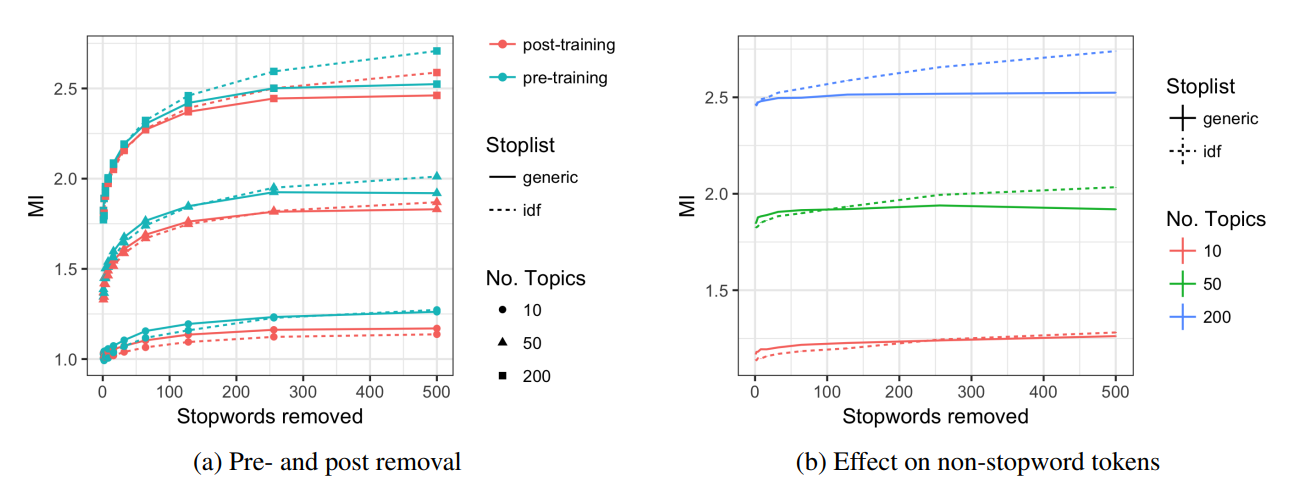

`MI score` đại diện cho mức độ mạch lạc và liên kết các từ -> đánh giá mức độ chặt chẽ rõ ràng.

Giải thích xíu thì hình bên trái là pre và post removal: 
- pre-training tốt hơn đường post-training và họ đánh giá là không đáng kể.
Hình bên phải là non-removal:
- Họ đánh giá là vẫn khá tốt.

**Note:** Đây là họ test trên bộ data 1%.
Sau đó, họ test trên bộ data 5%


*We compare the inferred log-likelihood of models trained
on our 1% New York Times sample on our larger
5% testing sample.*

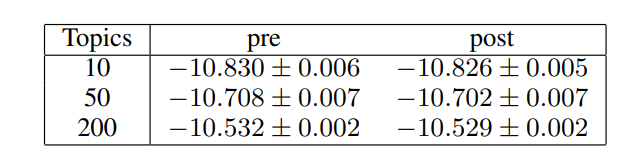

Họ đánh giá log-likehood cả hai gần như khá tương đồng -> Mức độ phân biệt ok.

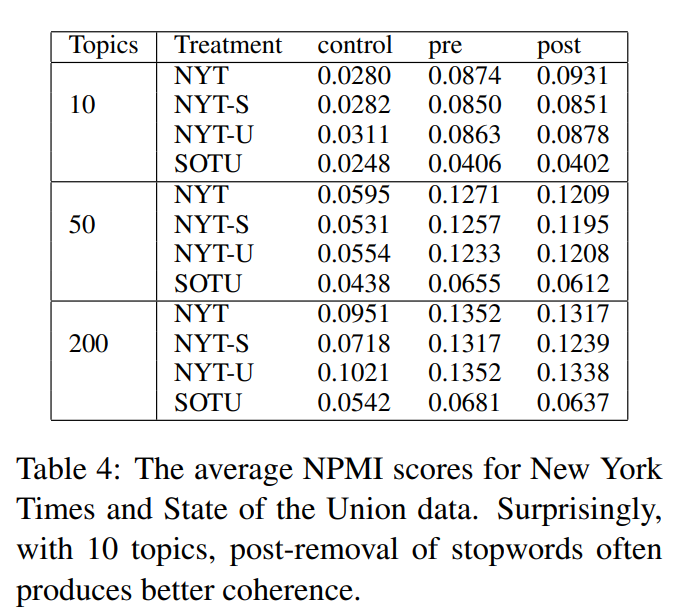

**Kết luận:**

Có thể rút ra vài điều:
- Mẫu test nhỏ -> không quá khác biệt giữa pre và post.
- Với mẫu test lớn hơn -> số topic nhỏ thì post làm tốt hơn với độ phân biệt là tương đồng. 

Xét theo việc efficient giữa pre-removal và post-removal thì:
- **Pre-removal** is about initial cleanup to simplify and speed up the main processing. 
- **Post-removal** is about refining the results of the main processing to improve accuracy and relevance.

**Áp dụng:**
Về bài toán này, em sẽ sử dụng *post-removal* vì em nghĩ cost khi implement không quá cao đến nỗi mình phải bỏ context of text.

## Sample code

#### Tokenizer

Ta sẽ sử dụng tokenizer từ BERT 

In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

text = "I am mathematicians. I am mathematician. I am mathematician."

# add_special_tokens=False: Loại bỏ CLS, UNK và SEP

encoded_input = tokenizer(text, return_tensors='pt',add_special_tokens=False)

# Get the input IDs which represent the indices of tokens in BERT's vocabulary
input_ids = encoded_input.input_ids
print(input_ids)
# Convert the input IDs back to tokens using tokenizer's decode method
tokens = tokenizer.decode(input_ids[0])

print(tokens)

tensor([[ 1045,  2572, 29374,  1012,  1045,  2572, 13235,  1012,  1045,  2572,
         13235,  1012]])
i am mathematicians. i am mathematician. i am mathematician.


In [5]:
tokens = tokenizer.decode(13235)

print(tokens)

m a t h e m a t i c i a n


In [6]:
from sklearn.metrics.pairwise import cosine_similarity


In [7]:
input_ids

tensor([[ 1045,  2572, 29374,  1012,  1045,  2572, 13235,  1012,  1045,  2572,
         13235,  1012]])

Trong tokenizer của BERT nó sẽ lowercase lại hết và mấy cái emoji nó sẽ báo là `UNK`, bây giờ mục tiêu ban đầu của mình là implement cái LDA trước nên coi như bỏ nha hehe.

Ngoài ra, khi sử dụng `BertTokenizer` tức là ta chuyển text thành `input_ids` được tính toán từ vector embedding dựa trên vocab của BERT. 
Để hiểu rõ hơn ta nên coi lại phần encoder trong phương pháp Transformer, có thể hiểu là khi input text, nó sẽ sử dụng toàn bộ cái text để phân tích ngữ cảnh.

VD: từ `present` nó sẽ sử dụng cả câu để suy luận nó mang nghĩa hiện tại hay món quà. Nên việc loại bỏ stopword khi pre-processing là 🐧.

In [9]:
df = pd.read_csv('reviews.csv')
df.head(2)

C:\Users\darkn\AppData\Local\Temp\ipykernel_26904\869865596.py:1: DtypeWarning: Columns (17,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('reviews.csv')


,hotel_id,hotel_name,addressline1,city,state,numberrooms,yearopened,yearrenovated,number_of_reviews,rating_average,...,reviewtitle,comment,positive,negative,score,accommodationtype1,accommodationtype2,accommodationtype3,accommodationtype4,language
0,163,Ramana Saigon Hotel,"323 Le Van Sy Street, District 3",Ho Chi Minh City,Ho Chi Minh,296.0,1996.0,2015.0,1713,8.1,...,HCM Short Trip”,A tourist class hotel with very basic amenitie...,NaN,NaN,6.4,Hotel,NaN,NaN,NaN,en
1,163,Ramana Saigon Hotel,"323 Le Van Sy Street, District 3",Ho Chi Minh City,Ho Chi Minh,296.0,1996.0,2015.0,1713,8.1,...,Hospitality low ”,The hotel rooms etc are good but very very sti...,NaN,NaN,7.6,Hotel,NaN,NaN,NaN,en


## TF-IDF truyền thống

### Bag of Word Approach

In [10]:
import string
sentences = df['0'].values
sentences[0]
dict = [str(sen).lower().split(' ') for sen in sentences]
# dict

KeyError: '0'

In [ ]:
from collections import defaultdict  # For word frequency

word_freq = defaultdict(int)

for sent in dict:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

Này là do mình chưa có remove stopword nên sài cái TF-IDF truyền thống nó toàn ra stopword thôi hehe!

Tiếp theo ta sẽ lấy stopword từ cái packages này `https://github.com/stopwords-iso/stopwords-iso?tab=readme-ov-file`:

In [ ]:
word_freq_ls = sorted(word_freq, key=word_freq.get, reverse=True)
word_freq_ls = {item.lower() for item in word_freq_ls}

In [ ]:
# word_freq.keys()
stop_word_eng = stopwords.stopwords("en")
for key in list(word_freq.keys()):  # Use list() to create a copy of keys to avoid runtime error
    if key in stop_word_eng:
        del word_freq[key]

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

### Tokenizer Approach

#### Tokenizer from BERT 

In [ ]:
text = "Hello, I am Grot"
text.translate(str.maketrans('', '', string.punctuation))

Đầu tiên là loại bỏ **punctuation** và **lower all case**.

In [ ]:
func = str.maketrans('', '', string.punctuation)
input = [str(sen).translate(func).lower() for sen in sentences]
input[:5]

Tokenizer mấy cái reviews thành token hết

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# encoded_input = tokenizer(input, return_tensors='pt',add_special_tokens=False,padding=True,truncation=True)
# input_ids = encoded_input.input_ids
# input_ids


Như cũ lấy stopword từ packages ra rồi encode dưới dạng token.

In [ ]:
stop_word_eng = stopwords.stopwords("en")
stop_word_encode = tokenizer(list(stop_word_eng), return_tensors='pt',add_special_tokens=False,padding=True,truncation=True)
stop_word_encode.input_ids[0]

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# encoded_input = tokenizer(input, return_tensors='pt',add_special_tokens=False,padding=True,truncation=True)
# input_ids = encoded_input.input_ids
# input_ids

dict = input_ids

word_freq = defaultdict(int)
for i in dict.flatten():
    word_freq[i.item()] += 1
len(word_freq)

Remove mấy cái stopwords trong `stopwords` package.

In [ ]:
for key in list(word_freq.keys()):  # Use list() to create a copy of keys to avoid runtime error
    if key in stop_word_encode.input_ids.flatten():
        del word_freq[key]

In [ ]:
# word_freq
sorted_list = sorted(word_freq, key=word_freq.get, reverse=True)[:20]
print(sorted_list)

In [ ]:
print(tokenizer.decode(sorted_list))

#### Tokenizer from phoBERT 

In [ ]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
stop_word_mul = stopwords.stopwords(["vi","en"])

In [ ]:
# encoded_input = tokenizer(input, return_tensors='pt',add_special_tokens=False,padding=True,truncation=True)
# input_ids = encoded_input.input_ids

# stop_word_encode = tokenizer(list(stop_word_mul), return_tensors='pt',add_special_tokens=False,padding=True,truncation=True)

# dict = input_ids
# word_freq = defaultdict(int)
# for i in dict.flatten():
#     word_freq[i.item()] += 1
# len(word_freq)

# for key in list(word_freq.keys()):  # Use list() to create a copy of keys to avoid runtime error
#     if key in stop_word_encode.input_ids.flatten():
#         del word_freq[key]

# sorted_list = sorted(word_freq, key=word_freq.get, reverse=True)[:20]
# print(sorted_list)
# print(tokenizer.decode(sorted_list))

## LDA

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim import corpora

texts = input

processed_texts = [[word for word in text.split()] for text in texts]

# Create a dictionary and a corpus using Gensim
dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

In [ ]:
def word_segmentation(text,language):
    if language == 'en':
        return nltk.word_tokenize(text)
    if language == 'vi':
        return ViTokenizer.tokenize(text).split(" ")
        

#### Implement LDA using Gensim

In [ ]:
# lda_model_gensim = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# # Display the topics
# for idx, topic in lda_model_gensim.print_topics(-1):
#     print(f"Topic: {idx} \nWords: {topic}")

Topic: 0 
Words: 0.062*"the" + 0.054*"and" + 0.025*"a" + 0.024*"to" + 0.021*"was" + 0.018*"very" + 0.018*"is" + 0.016*"staff" + 0.014*"hotel" + 0.014*"great"
Topic: 1 
Words: 0.055*"the" + 0.037*"to" + 0.032*"we" + 0.029*"and" + 0.027*"was" + 0.025*"i" + 0.019*"a" + 0.015*"they" + 0.014*"for" + 0.013*"in"
Topic: 2 
Words: 0.021*"và" + 0.018*"tôi" + 0.014*"có" + 0.013*"phòng" + 0.012*"rất" + 0.011*"khách" + 0.009*"sạn" + 0.008*"sẽ" + 0.008*"chúng" + 0.008*"không"
Topic: 3 
Words: 0.067*"the" + 0.029*"a" + 0.026*"is" + 0.024*"and" + 0.019*"to" + 0.016*"but" + 0.016*"in" + 0.015*"was" + 0.014*"room" + 0.014*"not"
Topic: 4 
Words: 0.009*"beautiful" + 0.008*"gia" + 0.007*"apartmentvery" + 0.004*"phong" + 0.004*"la" + 0.004*"co" + 0.003*"le" + 0.003*"y" + 0.003*"tien" + 0.003*"se"

In [ ]:
# lda.update(other_corpus)
# vector = lda[unseen_doc]

# lda = LdaModel(common_corpus, num_topics=50, alpha='auto', eval_every=5)  # learn asymmetric alpha from data

Function `remove_stopwords_from_topics` được tạo từ để loại bỏ các stopwords khi output:

In [ ]:
def remove_stopwords_from_topics(lda_model,stop_words):
    num_words = len(dictionary)  # Set num_words to the size of the vocabulary
    topics = lda_model.show_topics(num_topics=-1, num_words=num_words, formatted=False)
    cleaned_topics = []
    for topic in topics:
        topic_id, word_probs = topic
        cleaned_words = [(word, prob) for word, prob in word_probs if word not in stop_words]
        cleaned_topics.append((topic_id, cleaned_words))
    return cleaned_topics

In [ ]:
# new_topics = remove_stopwords_from_topics(lda_model_gensim,stop_word_mul)
# for idx, topic in new_topics:
#     print(f"Topic: {idx} \nWords: {topic[:10]}")

Topic: 0 
Words: [('staff', 0.016115531), ('hotel', 0.014353678), ('stay', 0.011004984), ('clean', 0.008398723), ('nice', 0.008205688), ('breakfast', 0.0080378195), ('location', 0.0076711145), ('friendly', 0.0073159956), ('helpful', 0.00704906), ('recommend', 0.0042071925)]
Topic: 1 
Words: [('hotel', 0.006172839), ('day', 0.0044599106), ('stay', 0.0040159863), ('staff', 0.0038200063), ('time', 0.0036179882), ('booked', 0.0035170333), ('night', 0.0033072655), ('check', 0.002266353), ('2', 0.0022532581), ('arrived', 0.0020869242)]
Topic: 2 
Words: [('phòng', 0.013310659), ('khách', 0.011121096), ('sạn', 0.008633182), ('chúng', 0.007960782), ('viên', 0.007770825), ('nhân', 0.0074022464), ('tốt', 0.005004567), ('tuyệt', 0.004698299), ('vời', 0.0045722197), ('thể', 0.004393904)]
Topic: 3 
Words: [('hotel', 0.011861363), ('nice', 0.005321804), ('breakfast', 0.0045877774), ('water', 0.0038832547), ('staff', 0.0037289297), ('clean', 0.0034728395), ('location', 0.003326692), ('bathroom', 0.0030651686), ('price', 0.0029874437), ('beach', 0.0029708738)]
Topic: 4 
Words: [('beautiful', 0.0094370935), ('gia', 0.0075656166), ('apartmentvery', 0.0072322106), ('phong', 0.0044747437), ('le', 0.0032319024), ('tien', 0.0026447636), ('phuc', 0.0024381396), ('bien', 0.0023661212), ('vien', 0.0023444456), ('tot', 0.002307421)]

#### Implement LDA using scikit-learn


In [ ]:
# # Vectorize the text
# vectorizer = CountVectorizer(stop_words='english')
# X = vectorizer.fit_transform(texts)

# # Fit the LDA model
# lda_model_sklearn = LatentDirichletAllocation(n_components=5, random_state=42)
# lda_model_sklearn.fit(X)

# # Display the topics
# for index, topic in enumerate(lda_model_sklearn.components_):
#     print(f"Topic {index}:")
#     print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Trong `CountVectorizer` đã có sẵn stopword nên config khá khó với những ngôn ngữ khác English.

#### WordCloud Visualization

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
def wordCloud(topics,id = 2,num_words = 10):
    
    all_words = [(topic_id, word_probs[:num_words]) for topic_id, word_probs in topics]
    word_freqs = {word: int(prob * 1000) for word, prob in all_words[id][1]}

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freqs)

    # Display the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
def wordCloud(topics,num_words = 10):

    num_topics = len(topics)
    # all_words = [(topic_id, word_probs[:num_words]) for topic_id, word_probs in topics]
    cols = 2  # Number of columns in the subplots grid
    rows = (num_topics + cols - 1) // cols  # Number of rows needed

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(13, 8))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D

    # word_freqs = {word: int(prob * 1000) for word, prob in all_words[topic_ids][1]}
    for i, (topic_id, word_probs) in enumerate(topics):
        # Calculate subplot position
        row = i // cols
        col = i % cols

        all_words = [(topic_id, word_probs[:num_words]) for topic_id, word_probs in topics]
        word_freqs = {word: int(prob * 1000) for word, prob in all_words[i][1]}
        
        # Generate the WordCloud for the current topic
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_freqs)

        # Plot the WordCloud on the corresponding subplot
        ax = axes[i]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Topic {topic_id}')
        ax.axis('off')

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    # Adjust layout
    plt.tight_layout()
    plt.show()

In [ ]:
# wordCloud(new_topics,len(dictionary))

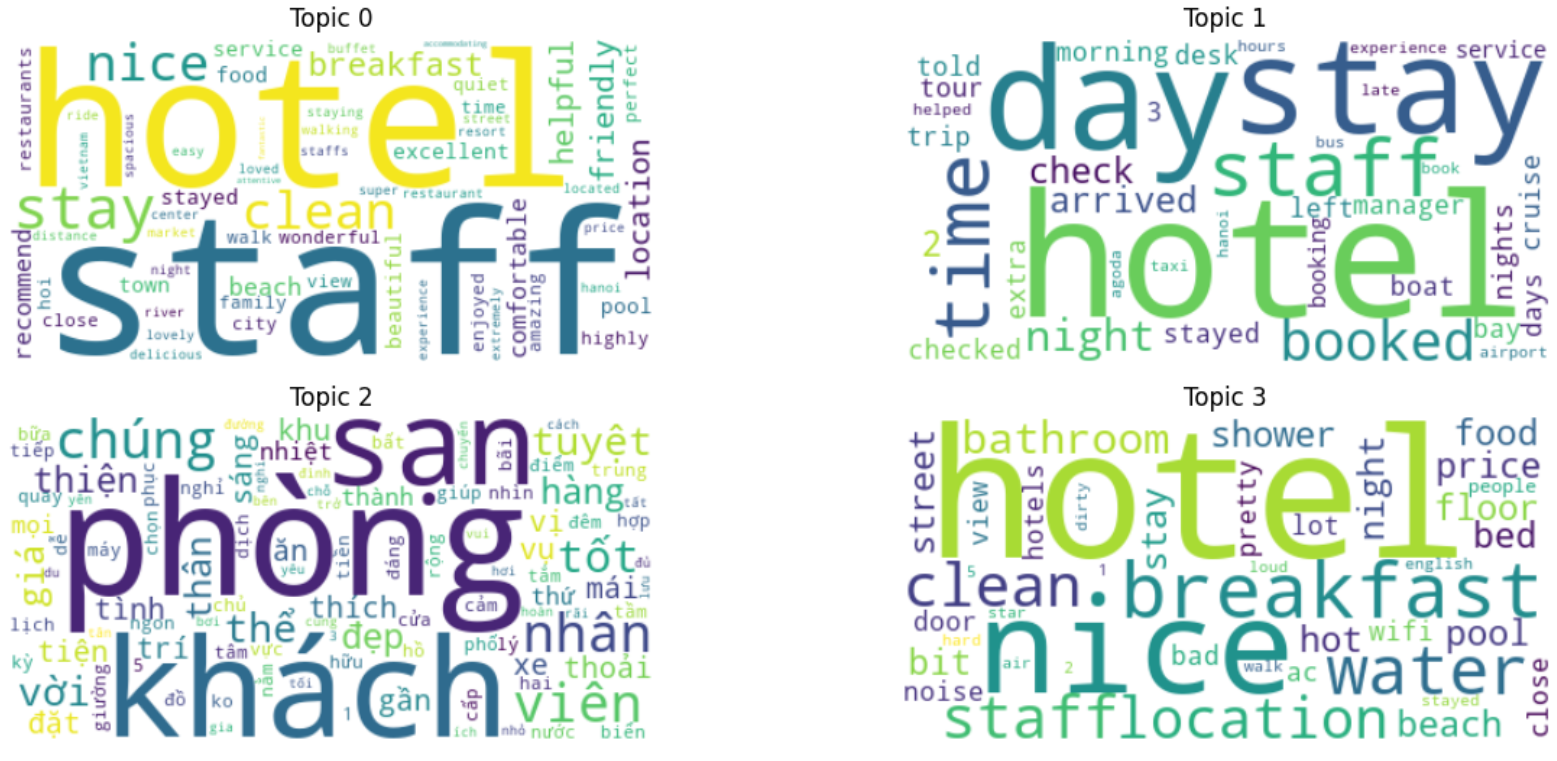

Ý tưởng sau này: Add thêm score trong khoảng [0,10] vào text và fade-in từ red thành green. 

In [ ]:
# def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
#     # Assuming word_freqs contains scores from 0 to 10
#     score = word_freqs.get(word, 0)
#     red = int(255 * (1 - score / 10))
#     green = int(255 * (score / 10))
#     return f"rgb({red}, {green}, 0)"

Trong khi làm phần này, mình found out thêm một vài thứ nữa. Ví dụ như khi xử lý data, `national` là quốc tịch người reviews. Tuy nhiên không có nghĩa là họ sẽ sử dụng tiếng Anh. Mình cần một phần mềm hay một cái gì đó để detect ra phần này.

#### Language Detect

In [ ]:
from transformers import pipeline

text = [
    "hotel good",
    "Amor, ch'a nullo amato amar perdona."
]

model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt)
pipe(text, top_k=1, truncation=True)

def detect_language(text):
    try:
        return pipe(text, top_k=1, truncation=True)
    except:
        return 'unknown'

# Add a new column with detected languages
df['language'] = df['comment'].apply(detect_language)

In [ ]:
def detect_language(text):
    try:
        return pipe(text, top_k=1, truncation=True)
    except:
        return 'unknown'

# Add a new column with detected languages
# df['language'] = df['comment'].apply(detect_language)

In [ ]:
national = "Vietnam"

In [ ]:
national in ["Việt Nam", "Viet Nam", "Vietnam"]